In [ ]:
# https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-#scrollTo=aQl0MMrOGIup

In [ ]:
!pip install seaborn

In [ ]:
!pip install transformers==3

In [1]:
import torch

In [2]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [3]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [4]:
question = "How many parameters does BERT-large have?"
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [5]:
input_ids = tokenizer.encode(question, answer_text)
print(input_ids)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

[101, 2129, 2116, 11709, 2515, 14324, 1011, 2312, 2031, 1029, 102, 14324, 1011, 2312, 2003, 2428, 2502, 1012, 1012, 1012, 2009, 2038, 2484, 1011, 9014, 1998, 2019, 7861, 8270, 4667, 2946, 1997, 1015, 1010, 6185, 2549, 1010, 2005, 1037, 2561, 1997, 16029, 2213, 11709, 999, 10462, 2009, 2003, 1015, 1012, 4090, 18259, 1010, 2061, 5987, 2009, 2000, 2202, 1037, 3232, 2781, 2000, 8816, 2000, 2115, 15270, 2497, 6013, 1012, 102]
The input has a total of 70 tokens.


In [6]:
#  BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
how           2,129
many          2,116
parameters   11,709
does          2,515
bert         14,324
-             1,011
large         2,312
have          2,031
?             1,029

[SEP]           102

bert         14,324
-             1,011
large         2,312
is            2,003
really        2,428
big           2,502
.             1,012
.             1,012
.             1,012
it            2,009
has           2,038
24            2,484
-             1,011
layers        9,014
and           1,998
an            2,019
em            7,861
##bed         8,270
##ding        4,667
size          2,946
of            1,997
1             1,015
,             1,010
02            6,185
##4           2,549
,             1,010
for           2,005
a             1,037
total         2,561
of            1,997
340          16,029
##m           2,213
parameters   11,709
!               999
altogether   10,462
it            2,009
is            2,003
1             1,015
.             1,01

In [7]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [8]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
print("start_scores---",start_scores)
print("end_scores---",end_scores)

start_scores--- tensor([[-6.4849, -6.4358, -8.1077, -8.8489, -7.8751, -8.0522, -8.4684, -8.5295,
         -7.7074, -9.2464, -6.4849, -2.7303, -6.3473, -5.7299, -7.7780, -7.0391,
         -6.3331, -7.3153, -7.3048, -7.4121, -2.2534, -5.3971, -0.9424, -7.3584,
         -5.4575, -7.0769, -4.4887, -3.9272, -5.6967, -5.9506, -5.0059, -5.9812,
          0.0530, -5.5968, -4.7093, -4.5750, -6.1786, -2.2294, -0.1904, -0.2327,
         -2.7331,  6.4256, -2.6543, -4.5655, -4.9872, -4.9834, -5.9110, -7.8402,
         -1.8986, -7.2123, -4.1543, -6.2354, -8.0953, -7.2329, -6.4411, -6.8384,
         -8.1032, -7.0570, -7.7332, -6.8711, -7.1045, -8.2966, -6.1939, -8.0817,
         -7.5501, -5.9695, -8.1008, -6.8849, -8.2273, -6.4850]],
       grad_fn=<SqueezeBackward1>)
end_scores--- tensor([[-2.0629, -6.3878, -6.2450, -6.3605, -7.0722, -7.6280, -7.1160, -6.8674,
         -7.1313, -7.1495, -2.0628, -5.0858, -4.7276, -3.5955, -6.3050, -7.1109,
         -4.4975, -4.7221, -5.4760, -5.5441, -6.1391, -5.859

In [9]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)
print(answer_start)
print(answer_end)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])
print(tokens[answer_start:answer_end])

print('Answer: "' + answer + '"')

tensor(41)
tensor(42)
['340']
Answer: "340 ##m"


In [10]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "340 ##m"


In [11]:
# Start with the first token.
answer = tokens[answer_start]

# he remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "340m"


In [12]:
# tyling from seaborn
# sns.set(style='darkgrid')
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot s
# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [13]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


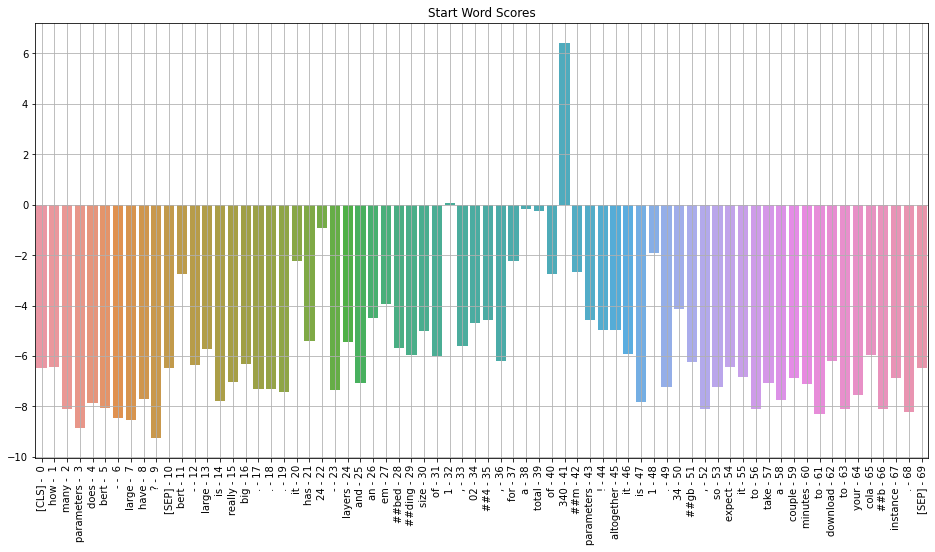

In [14]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

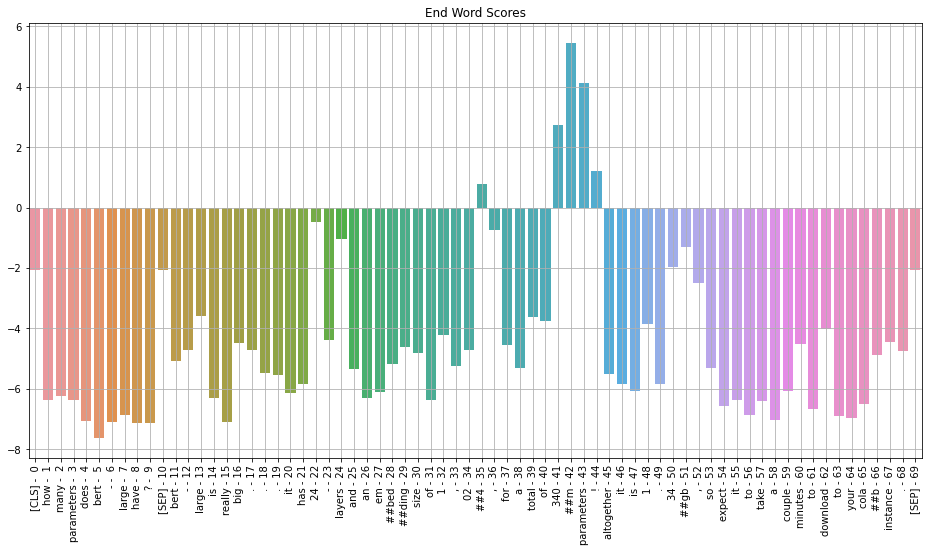

In [15]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

In [16]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


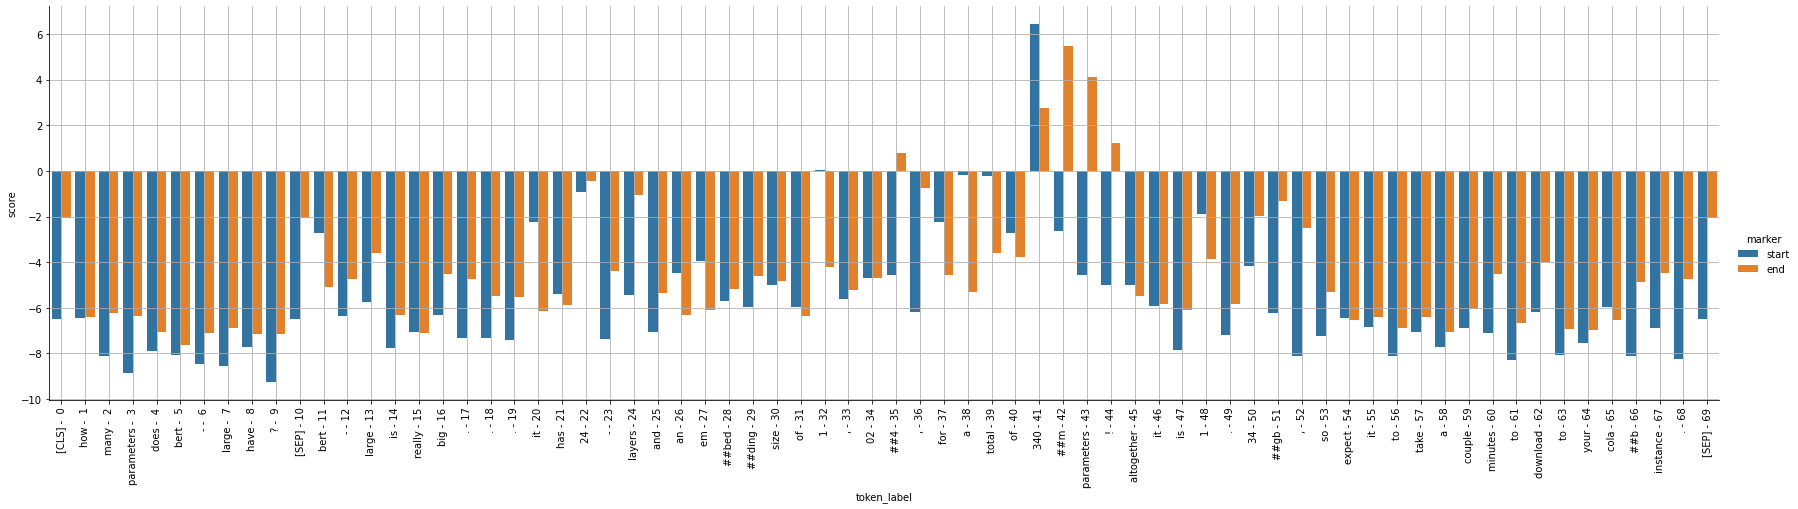

In [17]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


In [18]:
# def answer_question(question, answer_text):
#     '''
#     Takes a `question` string and an `answer_text` string (which contains the
#     answer), and identifies the words within the `answer_text` that are the
#     answer. Prints them out.
#     '''
#     # ======== Tokenize ========
#     # Apply the tokenizer to the input text, treating them as a text-pair.
#     input_ids = tokenizer.encode(question, answer_text)

#     # Report how long the input sequence is.
#     print('Query has {:,} tokens.\n'.format(len(input_ids)))

#     # ======== Set Segment IDs ========
#     # Search the input_ids for the first instance of the `[SEP]` token.
#     sep_index = input_ids.index(tokenizer.sep_token_id)

#     # The number of segment A tokens includes the [SEP] token istelf.
#     num_seg_a = sep_index + 1

#     # The remainder are segment B.
#     num_seg_b = len(input_ids) - num_seg_a

#     # Construct the list of 0s and 1s.
#     segment_ids = [0]*num_seg_a + [1]*num_seg_b

#     # There should be a segment_id for every input token.
#     assert len(segment_ids) == len(input_ids)

#     # ======== Evaluate ========
#     # Run our example question through the model.
#     start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
#                                     token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

#     # ======== Reconstruct Answer ========
#     # Find the tokens with the highest `start` and `end` scores.
#     answer_start = torch.argmax(start_scores)
#     answer_end = torch.argmax(end_scores)

#     # Get the string versions of the input tokens.
#     tokens = tokenizer.convert_ids_to_tokens(input_ids)

#     # Start with the first token.
#     answer = tokens[answer_start]

#     # Select the remaining answer tokens and join them with whitespace.
#     for i in range(answer_start + 1, answer_end + 1):
        
#         # If it's a subword token, then recombine it with the previous token.
#         if tokens[i][0:2] == '##':
#             answer += tokens[i][2:]
        
#         # Otherwise, add a space then the token.
#         else:
#             answer += ' ' + tokens[i]

#     print('Answer: "' + answer + '"')

In [20]:
bert_abstract ="""

Three heavy earth moving machine operators were killed after being hit by rocks and boulders during a landslide on the Rishikesh-Badrinath National Highway-58 in Uttarakhand early Monday August 24, 2020, officials said.
Monsoon 2020: Landslide in Uttarakhand's Chamoli damaged several shops and blocked the Badrinath national highway on Tuesday August 11, 2020. A police post was also damaged. There are no reports of anyone being injured. The hill state is seeing heavy rainfall since last night.
While four of the bodies have been extracted and an injured has been shifted to the hospital, search is on for six more at the landslide location in Kot village near Buda Kedar area in Uttarakhand. 4 Dead After Landslide In Uttarakhand's Tehri Garhwal, Rescue Underway
"""

In [21]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

# bert_abstract =

print(wrapper.fill(bert_abstract))

  Three heavy earth moving machine operators were killed after being hit by
rocks and boulders during a landslide on the Rishikesh-Badrinath National
Highway-58 in Uttarakhand early Monday August 24, 2020, officials said. Monsoon
2020: Landslide in Uttarakhand's Chamoli damaged several shops and blocked the
Badrinath national highway on Tuesday August 11, 2020. A police post was also
damaged. There are no reports of anyone being injured. The hill state is seeing
heavy rainfall since last night. While four of the bodies have been extracted
and an injured has been shifted to the hospital, search is on for six more at
the landslide location in Kot village near Buda Kedar area in Uttarakhand. 4
Dead After Landslide In Uttarakhand's Tehri Garhwal, Rescue Underway


In [22]:
question = "when lanslide happened?"

answer_question(question, bert_abstract)

Query has 174 tokens.

Answer: "august 24 , 2020"


In [ ]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')